# Score-Matching Langevin Dynamics

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal

## Langevin Dynamics using the true score function

We begin by implementing Langevin Dynamics which has theoretical guarantees as proven in the paper.

In [2]:
SAMPLES = 100
NUM_STEPS = 10000
LR = 0.01

### Implementation 1: 1D Langevin Dynamics Converging to GMM distribution
1D Gaussian mixture model with 0.5 chance being centered around 2 and 0.5 chance being centered around -2.

In [3]:
def langevin_dynamics(score, x, num_steps=NUM_STEPS, step_size=LR):
    """
    Langevin dynamics implemented as shown in Sohl-Dickstein et al. 2015
    """
    for _ in range(num_steps):
        score_x = score(x)
        x = x + 0.5 * step_size * torch.autograd.grad(score_x.sum(), x, create_graph=True)[0]
        x += np.sqrt(step_size) * torch.randn_like(x)
    return x

In [4]:
def mixture_of_gaussians(x):
    """
    Score function for a mixture of two Gaussians, one at -2 and one at 2 with unit variance and equal weights.
    """
    return torch.log(0.5 * torch.exp(-0.5 * (x - 2).pow(2)) + 0.5 * torch.exp(-0.5 * (x + 2).pow(2)))

We start by sampling points uniformly and show what the effect will be when performing Langevin Dynamics on them. Note that in theory we would've needed for the prior to be with the same support as the posterior, but empirically this doesn't seem to be too important.

In [5]:
def visualize_samples(samples):
    plt.hist(samples.detach().numpy(), bins=100, density=True)
    plt.show()

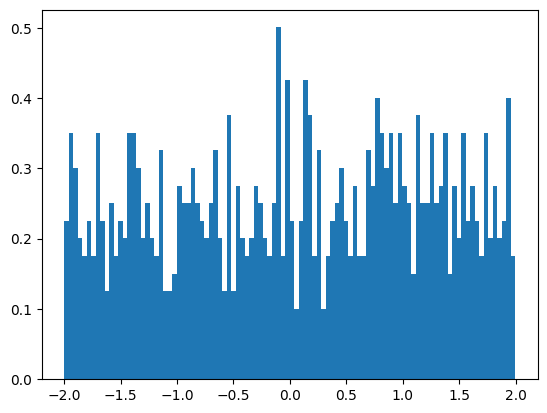

In [6]:
sample = torch.rand(1000, requires_grad=True) * 4 - 2
final = langevin_dynamics(mixture_of_gaussians, sample)
visualize_samples(sample)

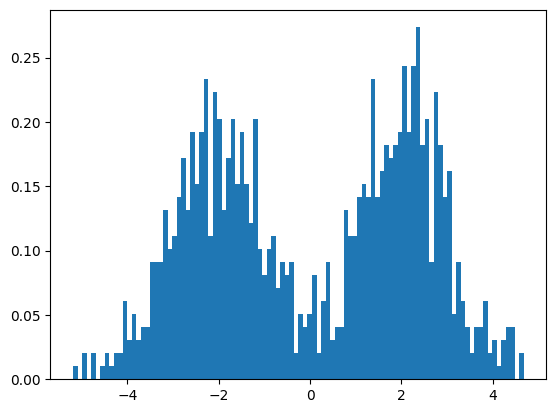

In [7]:
visualize_samples(final)

### Implementation 2: Multivariate Langevin Dynamics
2D multivariate normal, GMM with 0.5 chance of being centered at (-1, -1) and 0.5 of being centered at (1, 1). Both have low variance for them to have essentially disjoint supports.

In [8]:
def mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1):
    normal1 = MultivariateNormal(mu1, sigma1 * torch.eye(mu1.shape[0]))
    normal2 = MultivariateNormal(mu2, sigma2 * torch.eye(mu2.shape[0]))

    return torch.log(p1 * torch.exp(normal1.log_prob(x)) + (1 - p1) * torch.exp(normal2.log_prob(x)))

In [9]:
sample = torch.randn(1000, 2, requires_grad=True)
mu1, sigma1 = torch.tensor([1., 1.]), 0.1
mu2, sigma2 = torch.tensor([-1., -1.]), 0.1
p1 = 0.5
final = langevin_dynamics(lambda x: mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1), sample)

In [25]:
def visualize_samples2(samples):
    plt.scatter(samples.detach().numpy()[:, 0], samples.detach().numpy()[:, 1], edgecolors='black', facecolors='none', alpha=0.5, s=1)
    plt.show()

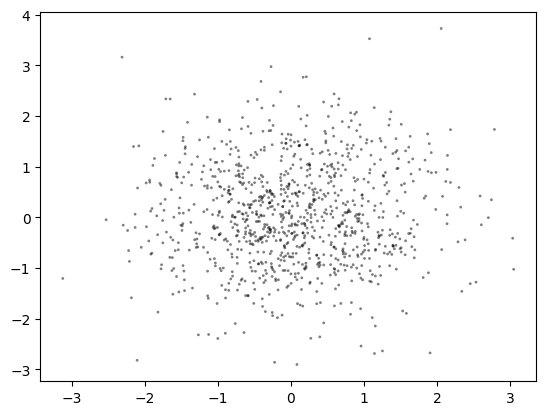

In [11]:
visualize_samples2(sample)

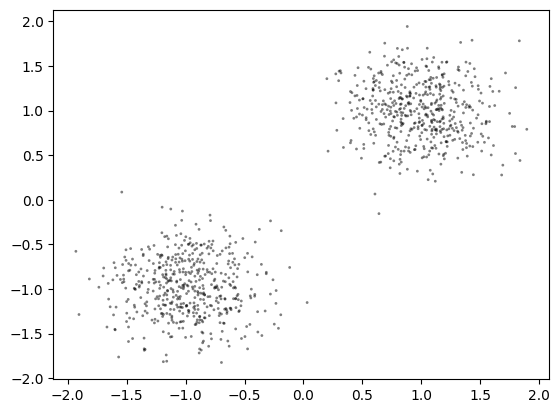

In [12]:
visualize_samples2(final)

### Implementation 3: Imbalanced GMM
What happens when the probability of being in one cluster are higher? This information is supposed to be hard to obtain in the process of taking the gradient.

In [13]:
sample = torch.randn(1000, 2, requires_grad=True)
p1 = 0.1

final = langevin_dynamics(lambda x: mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1), sample)

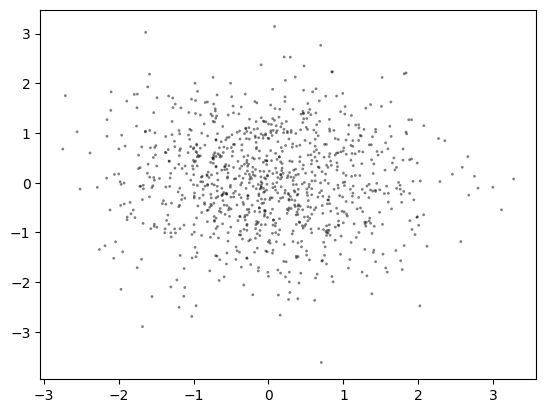

In [14]:
visualize_samples2(sample)

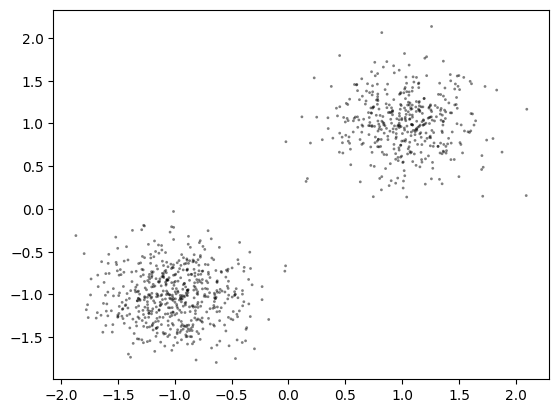

In [15]:
visualize_samples2(final)

It is still equally divided. The distribution is supposed to appear as follows:

In [16]:
true_prob = torch.rand(1000) < p1
true_prob = true_prob.float()

normal1 = MultivariateNormal(mu1, sigma1 * torch.eye(mu1.shape[0]))
normal2 = MultivariateNormal(mu2, sigma2 * torch.eye(mu2.shape[0]))


true_sample = torch.stack([normal1.sample() if p else normal2.sample() for p in true_prob])

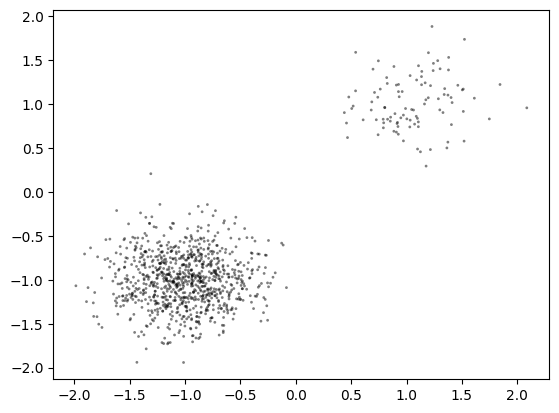

In [17]:
visualize_samples2(true_sample)

### Implementation 4: Noise Conditional Langevin Dynamics
Add decreasing noise to the data until convergence.

In [18]:
def annealed_langevin_dynamics(score, x, sigmas, num_steps=NUM_STEPS, step_size=LR):
    for sigma in sigmas:
        eps = (sigma / sigmas[-1]) ** 2 * step_size if sigma > 0 else step_size
        for _ in range(num_steps):
            score_x = score(x, sigma)
            x = x + 0.5 * eps * torch.autograd.grad(score_x.sum(), x, create_graph=True)[0]
            x += np.sqrt(eps) * torch.randn_like(x)
        plt.scatter(x.detach().numpy()[:, 0], x.detach().numpy()[:, 1], edgecolors='black', facecolors='none', alpha=0.5, s=1)
        plt.title(f"sigma = {sigma}")
        plt.show()
    return x

In [34]:
torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10)

tensor([1.0000, 0.5995, 0.3594, 0.2154, 0.1292, 0.0774, 0.0464, 0.0278, 0.0167,
        0.0100])

In [19]:
def mixture_of_gaussians3(x, noise):
    normal1 = MultivariateNormal(mu1, (noise + sigma1) * torch.eye(mu1.shape[0]))
    normal2 = MultivariateNormal(mu2, (noise + sigma2) * torch.eye(mu2.shape[0]))

    return torch.log(p1 * torch.exp(normal1.log_prob(x)) + (1 - p1) * torch.exp(normal2.log_prob(x)))

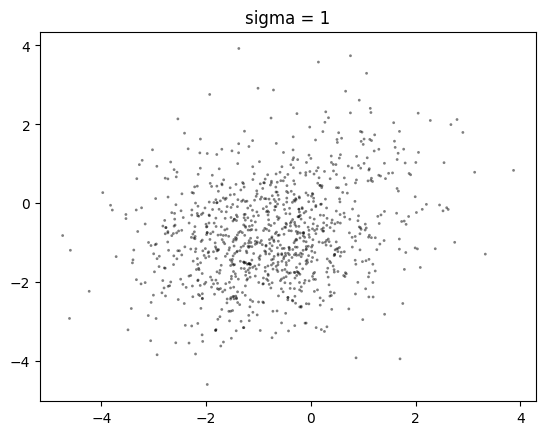

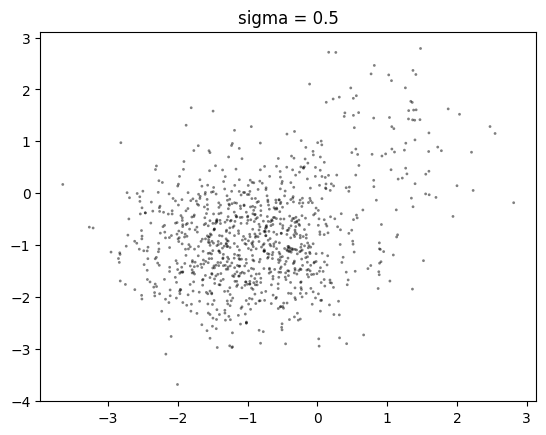

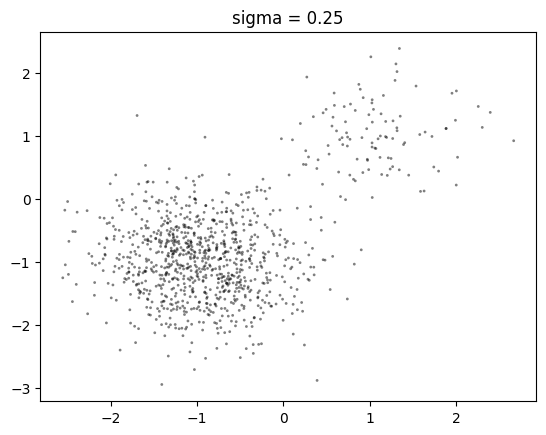

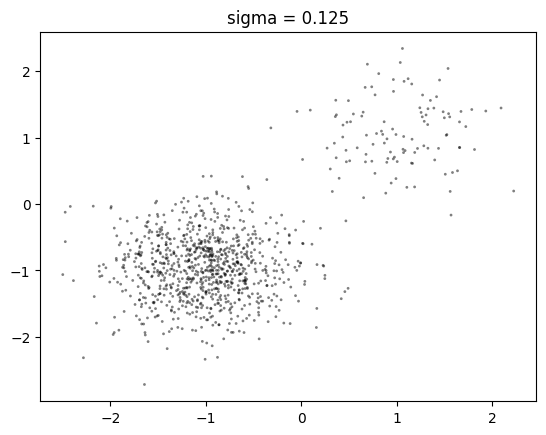

In [20]:
sample = torch.randn(1000, 2, requires_grad=True)
sigmas = [1, 0.5, 0.25, 0.125]
result = annealed_langevin_dynamics(mixture_of_gaussians3, sample, sigmas)

We can see that the annealed Langevin Dynamics do much better at estimating the distribution when it is not "even".

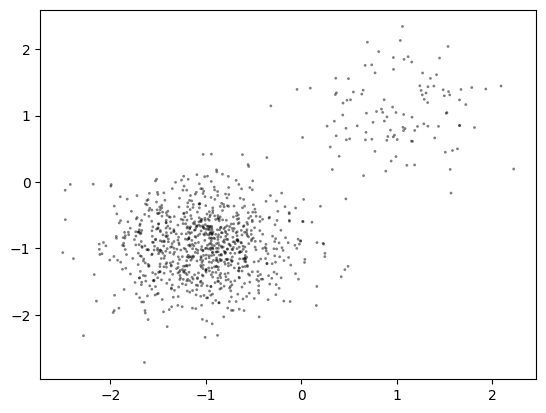

In [21]:
visualize_samples2(result)

## Langevin Dynamics using a score matcher

### Score Matching for multivariate normal

Now, we will implement a score-matching mechanism and use it to run Langevin Dynamics

We will start by implementing regular SMLD on the multivariate Gaussian, then use something more complicated for more complex distributions.

In [4]:
class FullyConnectedScoreMatcher(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FullyConnectedScoreMatcher, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = input_dim

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def langevin_dynamics(self, x, num_steps=NUM_STEPS, step_size=LR):
        for _ in range(num_steps):
            score = self(x)
            x = x + step_size * score + torch.randn_like(x) * np.sqrt(2 * step_size)
        return x
    
    def sample(self, num_samples=1000):
        x = torch.randn(num_samples, self.input_dim)
        return self.langevin_dynamics(x)
    
    

In [23]:
train_X = torch.randn(1000, 2) * torch.sqrt(torch.tensor([0.1])) + torch.tensor([1., 1.], requires_grad=True)

# get the score function of the standard normal distribution
distribution = MultivariateNormal(torch.tensor([1.0,1.0]), 0.1 * torch.eye(2))
score = torch.autograd.grad(distribution.log_prob(train_X).sum(0), train_X)[0]

In [24]:
model = FullyConnectedScoreMatcher(2, 128)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [25]:
for _ in range(1000):
    optimizer.zero_grad()
    score_pred = model(train_X)
    loss = criterion(score_pred, score)
    loss.backward()
    optimizer.step()

In [26]:
samples = model.sample(1000)

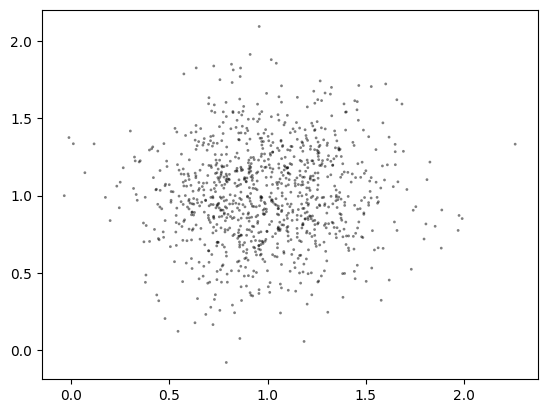

In [27]:
visualize_samples2(samples)

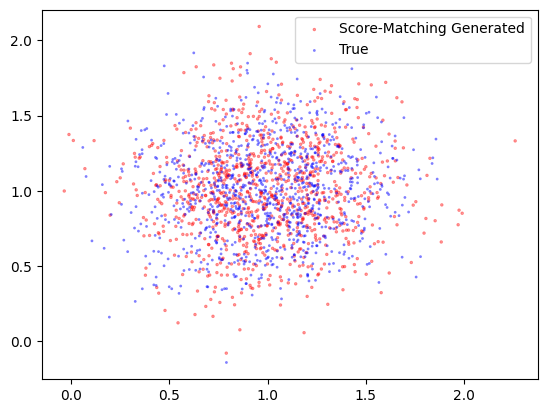

In [28]:
true_sample = distribution.sample((1000,))


plt.scatter(samples.detach().numpy()[:, 0], samples.detach().numpy()[:, 1], edgecolors='red', facecolors='none', alpha=0.5, s=2)
plt.scatter(true_sample[:, 0], true_sample[:, 1], edgecolors='blue', facecolors='none', alpha=0.5, s=1)
plt.legend(["Score-Matching Generated", "True"])
plt.show()

Using relatively small training data (1000 points) we were able to train a score network that can approximate the desired distribution. This is relatively easier using normal (Gaussian) distributions because they are very well-behaved. This is due to the distribution being very smooth. Distributions of images are of course much more complex, with many more variables (784 in MNIST) and much more sharp, unsmooth spikes in the density.

### Score Matching with a Mixture of Gaussians

We want to see how the score matcher will behave in cases where annealed LD might be necessary, such as regions with low density. Note that if the regions are far enough, we can ignore the influence of each region on each other in the score.

In [23]:
probabilities = torch.rand(1000) < 0.1
distribution1 = MultivariateNormal(torch.tensor([1.0,1.0]), 0.01 * torch.eye(2))
distribution2 = MultivariateNormal(torch.tensor([-1.0,-1.0]), 0.01 * torch.eye(2))

# where the probability is true, sample from the first distribution, otherwise sample from the second
score_x = lambda x, dist: torch.autograd.grad(dist.log_prob(x).sum(), x)[0]
X = torch.randn(1000, 2, requires_grad=True)
mu_1 = torch.tensor([1., 1.])
mu_2 = torch.tensor([-1., -1.])
sigma = 0.1

train_X = torch.stack([X[i] * sigma + mu_1 if probabilities[i] else X[i] * sigma + mu_2 for i in range(len(X))])
train_Y = torch.stack([score_x(train_X[i], distribution1) if probabilities[i] else score_x(train_X[i], distribution2) for i in range(len(train_X))])


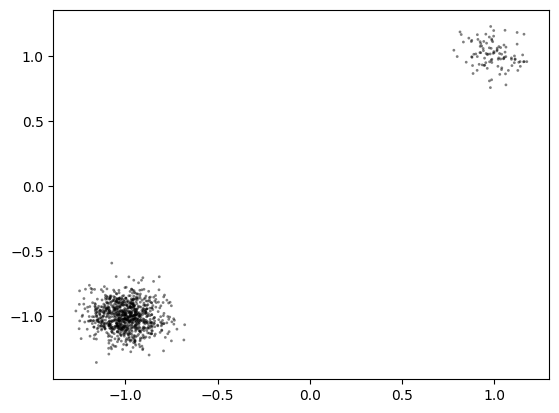

In [26]:
visualize_samples2(train_X)

In [27]:
model = FullyConnectedScoreMatcher(2, 128)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [29]:
for _ in range(1000):
    optimizer.zero_grad()
    score_pred = model(train_X)
    loss = criterion(score_pred, train_Y)
    loss.backward(retain_graph=True)
    optimizer.step()

Problem 1: Unable to learn the weights. I did kind of cheat by taking only the score of the respective marginal distribution instead of taking the score of the entire distribution. However the gradients would be very close to 0 anyway so I wanted to keep it simple.

In [ ]:
samples = model.sample(1000)

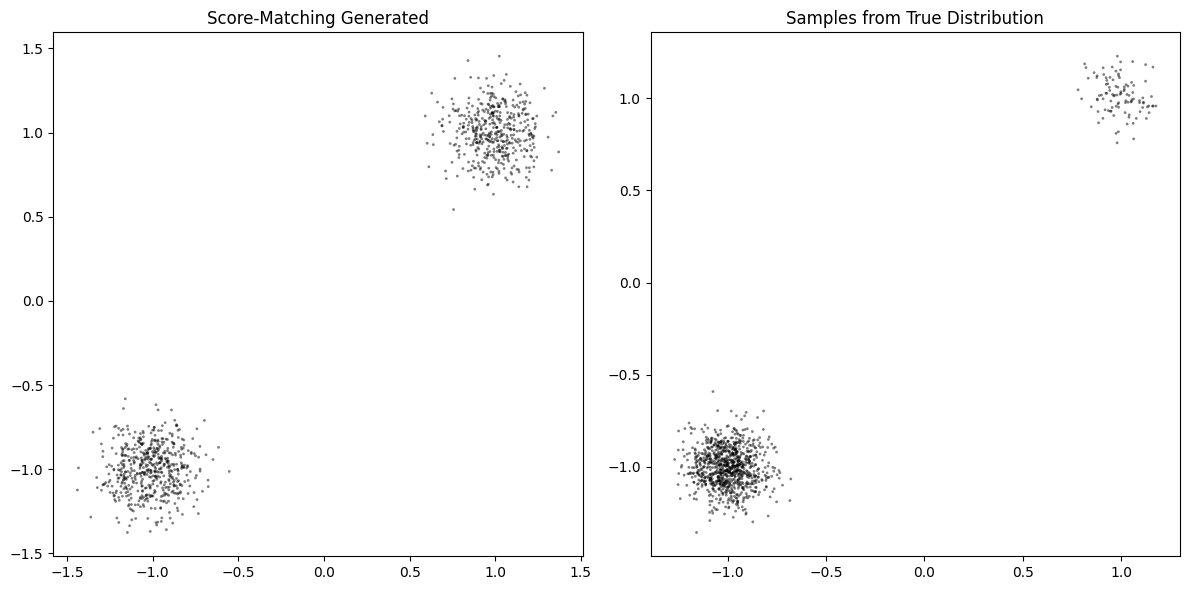

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(samples.detach().numpy()[:, 0], samples.detach().numpy()[:, 1], edgecolors='black', facecolors='none', alpha=0.5, s=1)
ax[1].scatter(train_X.detach().numpy()[:, 0], train_X.detach().numpy()[:, 1], edgecolors='black', facecolors='none', alpha=0.5, s=1)

ax[0].set_title("Score-Matching Generated")
ax[1].set_title("Samples from True Distribution")

plt.tight_layout()
plt.show()

Problem 2: We would expect the score at 0 to be exactly 0. However, because the likelihood of sampling 0 in the distribution is very low, it is not represented in the train data. What this means is that the score matcher will be very inaccurate in regions with low density.

In [19]:
mu_1 = torch.tensor([1., 1.])
mu_2 = torch.tensor([-1., -1.])
sigma = 0.1
p = 0.3

distribution1 = MultivariateNormal(mu_1, sigma * torch.eye(2))
distribution2 = MultivariateNormal(mu_2, sigma * torch.eye(2))

def density(x):
    return p * distribution1.log_prob(x).exp() + (1-p) * distribution2.log_prob(x).exp()

def true_score(x):
    return -1 / sigma * (p * distribution1.log_prob(x).exp() * (x - mu_1) + (1-p) * distribution2.log_prob(x).exp() * (x - mu_2)) / density(x)

In [20]:
train_X = torch.randn(1000, 2)
probabilities = torch.rand(1000) < p
train_X = torch.stack([train_X[i] * np.sqrt(sigma) + mu_1 if probabilities[i] else train_X[i] * np.sqrt(sigma) + mu_2 for i in range(len(train_X))])
train_Y = torch.stack([true_score(train_X[i]) for i in range(len(train_X))])

In [21]:
model = FullyConnectedScoreMatcher(2, 128)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for _ in range(1000):
    optimizer.zero_grad()
    score_pred = model(train_X)
    loss = criterion(score_pred, train_Y)
    loss.backward()
    optimizer.step()

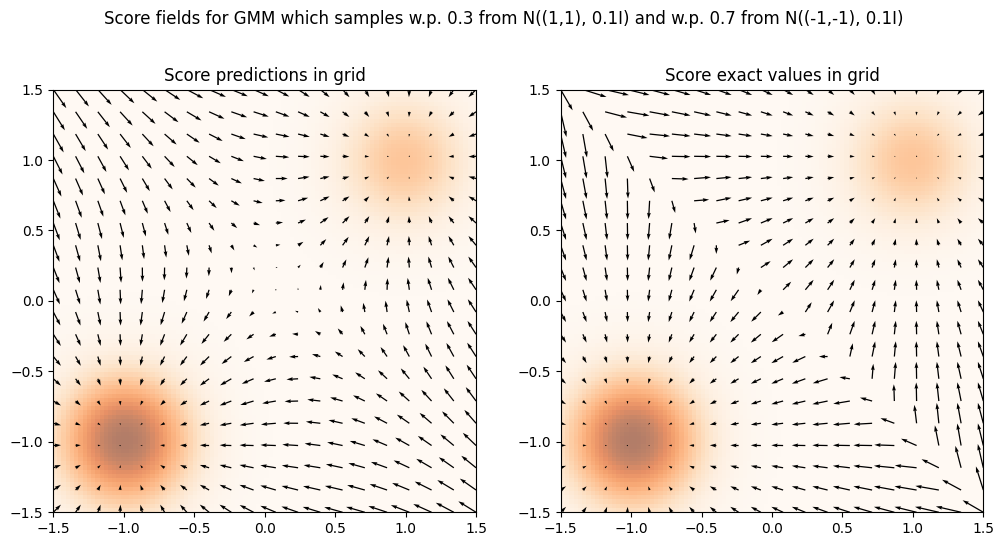

In [22]:
# create a grid in torch from -1.5 to 1.5 in 100 steps
x = torch.linspace(-1.5, 1.5, 20)
y = torch.linspace(-1.5, 1.5, 20)
X, Y = torch.meshgrid(x, y)

density_grid = torch.meshgrid(torch.linspace(-1.5, 1.5, 100), torch.linspace(-1.5, 1.5, 100))
density_values = torch.zeros_like(density_grid[0])

for i in range(100):
    for j in range(100):
        density_values[i,j] = density(torch.tensor([density_grid[0][i,j], density_grid[1][i,j]]))

# for every pair, compute model((x,y)). then draw a vector from (x,y) to (x+model((x,y))[0], y+model((x,y))[1])
U = torch.zeros_like(X)
V = torch.zeros_like(Y)
for i in range(20):
    for j in range(20):
        score = model(torch.tensor([X[i,j], Y[i,j]]))
        U[i,j] = score[0]
        V[i,j] = score[1]

# show true score values according to Multivariate normal with means (-1,-1), (1,1) and variance 0.1
U2 = torch.zeros_like(X)
V2 = torch.zeros_like(Y)
for i in range(20):
    for j in range(20):
        score = true_score(torch.tensor([X[i,j], Y[i,j]]))
        U2[i,j] = score[0]
        V2[i,j] = score[1]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot predicted scores on the left
ax[0].imshow(density_values.detach().numpy(), extent=(-1.5, 1.5, -1.5, 1.5), origin='lower', cmap='Oranges', alpha=0.6)
ax[0].quiver(X, Y, U.detach().numpy(), V.detach().numpy())
ax[0].set_title("Score predictions in grid")

# Plot true scores on the right
ax[1].imshow(density_values.detach().numpy(), extent=(-1.5, 1.5, -1.5, 1.5), origin='lower', cmap='Oranges', alpha=0.6)
ax[1].quiver(X, Y, U2.detach().numpy(), V2.detach().numpy())
ax[1].set_title("Score exact values in grid")

fig.suptitle("Score fields for GMM which samples w.p. 0.3 from N((1,1), 0.1I) and w.p. 0.7 from N((-1,-1), 0.1I)")

# Display the figure
plt.show()

### Score matching for MNIST images.

In this case, we need a more fit architecture, such as the U-Net. Additionally, we need to understand what the exact probability distribution is. This is what annealed LD is good for, because the distribution we have is only the empirical distribution of the train set and adding Gaussian noise to that distribution will be what smoothens the density greatly. We will be using denoising score matching, so as to make the 

UNET implementation based on open source: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, 3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, output_dim, 3, padding=1),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Downscaler(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Downscaler, self).__init__()
        self.downscaler = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(input_dim, input_dim, output_dim)
        )

    def forward(self, x):
        return self.downscaler(x)
    

class Upscaler(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Upscaler, self).__init__()
        self.upscaler = nn.ConvTranspose2d(input_dim, output_dim, 2, stride=2)
        self.conv = DoubleConv(input_dim, input_dim, output_dim)

    def forward(self, x1, x2):
        x1 = self.upscaler(x1)
        # match dimensions of x1 and x2 by adding padding to x1.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(UNet, self).__init__()
        self.inc = DoubleConv(input_dim + 1, 16, 32)
        self.down1 = Downscaler(32, 64)
        self.down2 = Downscaler(64, 128)
        self.down3 = Downscaler(128, 256)
        self.down4 = Downscaler(256, 512)
        self.up1 = Upscaler(512, 256)
        self.up2 = Upscaler(256, 128)
        self.up3 = Upscaler(128, 64)
        self.up4 = Upscaler(64, 32)
        self.outc = nn.Conv2d(32 + 1, output_dim, 1)

    def embed_sigma(self, sigma, shape):
        return sigma.view(-1, 1, 1, 1).expand(-1, 1, shape[2], shape[3])

    def forward(self, x, sigma):
        sigma = self.embed_sigma(sigma, x.shape)
        x = torch.cat([x, sigma], dim=1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = torch.cat([x, sigma], dim=1)
        x = self.outc(x)
        return x

In [7]:
class ScoreMatchingUNet(UNet):
    def __init__(self, input_dim, output_dim, device):
        super(ScoreMatchingUNet, self).__init__(input_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.device = device

    def annealed_langevin_dynamics(self, x, num_steps, step_size):
        self.eval()
        with torch.no_grad():
            for sigma in torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(self.device):
                eps = (sigma / 0.01) ** 2 * step_size
                sigma_tensor = torch.full((x.shape[0], 1, 1, 1), sigma).to(self.device)
                for i in range(num_steps):
                    score_x = self(x, sigma_tensor)
                    x = x + 0.5 * eps * score_x
                    x += torch.sqrt(eps) * torch.randn_like(x)
                    torch.cuda.empty_cache()
            return x.detach().cpu().numpy()

    def sample(self, num_samples=1000, height=28, width=28, num_steps=300, step_size=0.001):
        x = torch.randn(num_samples, self.input_dim, height, width).to(device)
        return self.annealed_langevin_dynamics(x, num_steps, step_size)

In [8]:
def denoising_loss(model, target, sigma):
    noise = torch.randn_like(target) * sigma
    noisy_target = target + noise
    score = model(noisy_target, sigma)
    target = -noise / (sigma ** 2)
    return 0.5 * ((score - target) ** 2).sum(dim=(1, 2, 3)).mean(dim=0)

In [9]:
model = ScoreMatchingUNet(1, 1, device)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
# use MNIST as train set
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, drop_last=True)



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17712006.32it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 470561.45it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4417629.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2211320.81it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [17]:
for epoch in range(100):
    print(f"Epoch {epoch}")
    overall_loss = 0
    for i, data in enumerate(tqdm(trainloader, desc="Training"), 0):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        loss = 0
        for sigma in torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(device):
            sigma_tensor = torch.full((inputs.shape[0], 1, 1, 1), sigma).to(device)
            loss += denoising_loss(model, inputs, sigma_tensor) * (sigma ** 2)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        torch.save(model, f"unet_epoch{epoch}.pth")
    print(f"Loss in epoch: {overall_loss / len(trainloader)}")


Epoch 0


Training:   0%|          | 0/937 [00:00<?, ?it/s]


NameError: name 'denoising_loss' is not defined

In [15]:
torch.save(model, 'final_model.pth')

Different model, code from https://github.com/DanyeongLee/ncsn-pytorch

In [4]:
class CondInstanceNorm(nn.Module):
    def __init__(self, in_channels, n_noise_scale=10, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(n_noise_scale, in_channels))
        self.beta = nn.Parameter(torch.zeros(n_noise_scale, in_channels))
        self.alpha = nn.Parameter(torch.zeros(n_noise_scale, in_channels))
        self.eps = eps

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)
        # noise_scale_idx: (batch_size)
        # gamma: (n_noise_scale, in_channels)

        bsz = x.shape[0]
        gamma = self.gamma[noise_scale_idx].view(bsz, -1, 1, 1)  # (bsz, in_channels, 1, 1)
        beta = self.beta[noise_scale_idx].view(bsz, -1, 1, 1)
        alpha = self.alpha[noise_scale_idx].view(bsz, -1, 1, 1)


        mu = x.mean(dim=(2, 3), keepdim=True)  # (batch_size, in_channels, 1, 1)
        var = x.var(dim=(2, 3), keepdim=True)  # (batch_size, in_channels, 1, 1)
        sigma = torch.sqrt(var + self.eps)  # (batch_size, in_channels, 1, 1)
        

        x = (x - mu) / sigma  # (batch_size, in_channels, height, width)
        x = gamma * x + beta  # (batch_size, in_channels, height, width)

        m = mu.mean(dim=1, keepdim=True)  # (batch_size, 1, 1, 1)
        if mu.shape[1] == 1:
            s = torch.ones_like(mu)
        else:
            v = mu.var(dim=1, keepdim=True)  # (batch_size, 1, 1, 1)
            s = torch.sqrt(v + self.eps)  # (batch_size, 1, 1, 1)

        x = x + alpha * (mu - m) / s  # (batch_size, in_channels, height, width)
        
        return x


class ResidualConvUnit(nn.Module):
    def __init__(self, channels, norm=True, kernel_size=3, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding='same')
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding='same')
        self.norm1 = CondInstanceNorm(channels, n_noise_scale) if norm else None
        self.norm2 = CondInstanceNorm(channels, n_noise_scale) if norm else None
        self.act = nn.ELU()

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        h = self.norm1(x, noise_scale_idx) if self.norm1 is not None else x
        h = self.act(h)
        h = self.conv1(h)

        h = self.norm2(h, noise_scale_idx) if self.norm2 is not None else h
        h = self.act(h)
        h = self.conv2(h)
        
        return x + h
    
    

class StridedConvUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, stride=2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding='same')
        self.norm1 = CondInstanceNorm(in_channels, n_noise_scale)
        self.norm2 = CondInstanceNorm(out_channels, n_noise_scale)
        self.act = nn.ELU()
    
    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        h = self.norm1(x, noise_scale_idx)
        h = self.act(h)
        h = self.conv1(h)

        h = self.norm2(h, noise_scale_idx)
        h = self.act(h)
        h = self.conv2(h)
        
        return h


class DilatedConvUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=2, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation, padding=dilation)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding='same')
        self.norm1 = CondInstanceNorm(in_channels, n_noise_scale)
        self.norm2 = CondInstanceNorm(out_channels, n_noise_scale)
        self.act = nn.ELU()

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        h = self.norm1(x, noise_scale_idx)
        h = self.act(h)
        h = self.conv1(h)

        h = self.norm2(h, noise_scale_idx)
        h = self.act(h)
        h = self.conv2(h)
        
        return h
    


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_layers=2, downsample='stride', dilation=2, n_noise_scale=10):
        assert downsample in ['stride', 'dilation']
        super().__init__()
        self.downsample = downsample
        self.main = nn.ModuleList([])
        for _ in range(n_layers):
            self.main.append(ResidualConvUnit(in_channels, n_noise_scale=n_noise_scale))
        
        if downsample == 'stride':
            self.main.append(StridedConvUnit(in_channels, out_channels, n_noise_scale=n_noise_scale))
        elif downsample == 'dilation':
            self.main.append(DilatedConvUnit(in_channels, out_channels, dilation=dilation, n_noise_scale=n_noise_scale))

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        for layer in self.main:
            x = layer(x, noise_scale_idx)
        
        return x
    

class AdaptiveConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = ResidualConvUnit(out_channels, n_noise_scale=n_noise_scale)
        self.conv3 = ResidualConvUnit(out_channels, n_noise_scale=n_noise_scale)

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        h = self.conv1(x)
        h = self.conv2(h, noise_scale_idx)
        h = self.conv3(h, noise_scale_idx)
        
        return h
    

class MultiResolutionFusion(nn.Module):
    def __init__(self, channels, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding='same')
        self.norm1 = CondInstanceNorm(channels, n_noise_scale)
        self.norm2 = CondInstanceNorm(channels, n_noise_scale)

    def forward(self, x, y=None, noise_scale_idx=0):
        if y is None:
            return x
        else:
            h1 = self.norm1(x, noise_scale_idx)
            h1 = self.conv1(h1)

            h2 = self.norm2(y, noise_scale_idx)
            h2 = self.conv2(h2)

            return h1 + h2
        

class ResidualPoolingBlock(nn.Module):
    def __init__(self, channels, n_noise_scale=10):
        super().__init__()
        self.norm1 = CondInstanceNorm(channels, n_noise_scale)
        self.pool1 = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)
        self.norm2 = CondInstanceNorm(channels, n_noise_scale)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding='same')

    def forward(self, x, noise_scale_idx):
        h = self.norm1(x, noise_scale_idx)
        h = self.pool1(h)
        h = self.norm2(h, noise_scale_idx)
        h = self.conv1(h)

        return h



class ChainedResidualPool(nn.Module):
    def __init__(self, channels, n_noise_scale=10):
        super().__init__()
        self.act = nn.ELU()
        self.pool1 = ResidualPoolingBlock(channels, n_noise_scale=n_noise_scale)
        self.pool2 = ResidualPoolingBlock(channels, n_noise_scale=n_noise_scale)


    def forward(self, x, noise_scale_idx):
        x = self.act(x)
        h = self.pool1(x, noise_scale_idx)
        x = x + h
        h = self.pool2(h, noise_scale_idx)
        x = x + h

        return x



class RefineNetBlock(nn.Module):
    def __init__(self, x1_in, x2_in, channels, n_noise_scale=10):
        super().__init__()
        self.adap_x1 = AdaptiveConvBlock(x1_in, channels, n_noise_scale=n_noise_scale)
        self.adap_x2 = AdaptiveConvBlock(x2_in, channels, n_noise_scale=n_noise_scale)

        self.fusion = MultiResolutionFusion(channels, n_noise_scale=n_noise_scale)
        self.pool = ChainedResidualPool(channels, n_noise_scale=n_noise_scale)

        self.out = ResidualConvUnit(channels, n_noise_scale=n_noise_scale)

    def forward(self, x1, x2=None, noise_scale_idx=0):
        h1 = self.adap_x1(x1, noise_scale_idx)
        h2 = self.adap_x2(x2, noise_scale_idx) if x2 is not None else None
        h = self.fusion(h1, h2, noise_scale_idx)
        h = self.pool(h, noise_scale_idx)
        h = self.out(h, noise_scale_idx)

        return h

In [5]:
class RefineNet(nn.Module):
    def __init__(self, in_channels, hidden_channels=(128, 256, 512, 1024), n_noise_scale=10):
        super().__init__()
        self.res1 = ResidualBlock(in_channels, hidden_channels[0], n_layers=2, downsample='stride')
        self.res2 = ResidualBlock(hidden_channels[0], hidden_channels[1], n_layers=2, downsample='dilation', dilation=2)
        self.res3 = ResidualBlock(hidden_channels[1], hidden_channels[2], n_layers=2, downsample='dilation', dilation=4)
        self.res4 = ResidualBlock(hidden_channels[2], hidden_channels[3], n_layers=2, downsample='dilation', dilation=8)
        
        self.refine1 = RefineNetBlock(x1_in=hidden_channels[-1], x2_in=hidden_channels[-1], channels=hidden_channels[-1], n_noise_scale=n_noise_scale)
        self.refine2 = RefineNetBlock(x1_in=hidden_channels[-2], x2_in=hidden_channels[-1], channels=hidden_channels[-2], n_noise_scale=n_noise_scale)
        self.refine3 = RefineNetBlock(x1_in=hidden_channels[-3], x2_in=hidden_channels[-2], channels=hidden_channels[-3], n_noise_scale=n_noise_scale)
        self.refine4 = RefineNetBlock(x1_in=hidden_channels[-4], x2_in=hidden_channels[-3], channels=hidden_channels[-4], n_noise_scale=n_noise_scale)

        self.up_norm = CondInstanceNorm(hidden_channels[-4], n_noise_scale)
        self.up_conv = nn.ConvTranspose2d(hidden_channels[-4], hidden_channels[-4], kernel_size=3, stride=2, padding=1, output_padding=1)
        self.out = AdaptiveConvBlock(hidden_channels[-4], in_channels, n_noise_scale=n_noise_scale)


    def forward(self, x, noise_scale_idx):
        h1 = self.res1(x, noise_scale_idx)
        h2 = self.res2(h1, noise_scale_idx)
        h3 = self.res3(h2, noise_scale_idx)
        h4 = self.res4(h3, noise_scale_idx)

        h = self.refine1(h4, x2=None, noise_scale_idx=noise_scale_idx)
        h = self.refine2(h3, h, noise_scale_idx)
        h = self.refine3(h2, h, noise_scale_idx)
        h = self.refine4(h1, h, noise_scale_idx)

        h = self.up_norm(h, noise_scale_idx)
        h = self.up_conv(h)
        h = self.out(h, noise_scale_idx)

        return h
    
def q_sample(x, sigma, noise=None):
    # x: (B, C, H, W)
    # sigma: (B, )
    if noise is None:
        noise = torch.randn_like(x)
    while sigma.dim() < x.dim():
        sigma = sigma.unsqueeze(-1)
    return x + sigma * noise
    
def score_matching_loss(model, x, noise_scales):
    noise_scale_idx = torch.randint(0, noise_scales.shape[0], (x.shape[0],), device=x.device)
    noise_scale_batch = noise_scales[noise_scale_idx].view(-1, 1, 1, 1)

    noise = torch.randn_like(x)
    x_noisy = q_sample(x, noise_scale_batch, noise=noise)
    score = model(x_noisy, noise_scale_idx)

    loss = F.mse_loss(noise_scale_batch * score, -noise)

    return loss

In [8]:
model2 = RefineNet(1, n_noise_scale=10).to(device)
model2 = nn.DataParallel(model2)
optimizer = optim.Adam(model2.parameters(), lr=1e-3)
noise_scales = torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(device)

for epoch in range(1, 61):
    print(f"Epoch {epoch}")
    overall_loss = 0
    for _, data in enumerate(tqdm(trainloader, desc="Training"), 0):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        loss = score_matching_loss(model2, inputs, noise_scales)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        torch.save(model2.module, f"refinenet_epoch{epoch}.pth")
    print(f"Loss in epoch: {overall_loss / len(trainloader)}")

Epoch 1


Training:   0%|          | 0/937 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training: 100%|██████████| 937/937 [17:43<00:00,  1.13s/it]


Loss in epoch: 0.2591755095801715
Epoch 2


Training: 100%|██████████| 937/937 [17:48<00:00,  1.14s/it]


Loss in epoch: 0.15571123055453742
Epoch 3


Training: 100%|██████████| 937/937 [17:46<00:00,  1.14s/it]


Loss in epoch: 0.11252490213993646
Epoch 4


Training: 100%|██████████| 937/937 [17:46<00:00,  1.14s/it]


Loss in epoch: 0.1063949258852921
Epoch 5


Training: 100%|██████████| 937/937 [17:46<00:00,  1.14s/it]


Loss in epoch: 0.10351676599638439
Epoch 6


Training: 100%|██████████| 937/937 [17:46<00:00,  1.14s/it]


Loss in epoch: 0.10111284433300492
Epoch 7


Training: 100%|██████████| 937/937 [17:47<00:00,  1.14s/it]


Loss in epoch: 0.11624369300353235
Epoch 8


Training: 100%|██████████| 937/937 [17:48<00:00,  1.14s/it]


Loss in epoch: 0.10052622747364014
Epoch 9


Training: 100%|██████████| 937/937 [17:48<00:00,  1.14s/it]


Loss in epoch: 0.09764615091691023
Epoch 10


Training: 100%|██████████| 937/937 [17:49<00:00,  1.14s/it]


Loss in epoch: 0.09642900707818401
Epoch 11


Training: 100%|██████████| 937/937 [17:46<00:00,  1.14s/it]


Loss in epoch: 0.09491079168646668
Epoch 12


Training: 100%|██████████| 937/937 [17:47<00:00,  1.14s/it]


Loss in epoch: 0.09457361559794068
Epoch 13


Training: 100%|██████████| 937/937 [17:46<00:00,  1.14s/it]


Loss in epoch: 0.09378925653665526
Epoch 14


Training: 100%|██████████| 937/937 [17:47<00:00,  1.14s/it]


Loss in epoch: 0.09337650487555256
Epoch 15


Training: 100%|██████████| 937/937 [17:46<00:00,  1.14s/it]


Loss in epoch: 0.09298097453574106
Epoch 16


Training: 100%|██████████| 937/937 [17:47<00:00,  1.14s/it]


Loss in epoch: 0.09296485284699192
Epoch 17


Training: 100%|██████████| 937/937 [17:47<00:00,  1.14s/it]


Loss in epoch: 0.09179914194052859
Epoch 18


Training: 100%|██████████| 937/937 [17:47<00:00,  1.14s/it]


Loss in epoch: 0.09079724507308948
Epoch 19


Training: 100%|██████████| 937/937 [17:47<00:00,  1.14s/it]


Loss in epoch: 0.08983512159949815
Epoch 20


Training: 100%|██████████| 937/937 [17:47<00:00,  1.14s/it]


Loss in epoch: 0.0888437468522768
Epoch 21


Training: 100%|██████████| 937/937 [17:51<00:00,  1.14s/it]


Loss in epoch: 0.08831006928626349
Epoch 22


Training: 100%|██████████| 937/937 [17:51<00:00,  1.14s/it]


Loss in epoch: 0.08760560943229222
Epoch 23


Training: 100%|██████████| 937/937 [17:51<00:00,  1.14s/it]


Loss in epoch: 0.08732725520843884
Epoch 24


Training: 100%|██████████| 937/937 [17:51<00:00,  1.14s/it]


Loss in epoch: 0.08712906334767856
Epoch 25


Training: 100%|██████████| 937/937 [17:51<00:00,  1.14s/it]


Loss in epoch: 0.08711471355330346
Epoch 26


Training: 100%|██████████| 937/937 [17:51<00:00,  1.14s/it]


Loss in epoch: 0.08671719646091268
Epoch 27


Training: 100%|██████████| 937/937 [17:51<00:00,  1.14s/it]


Loss in epoch: 0.08633988081073049
Epoch 28


Training: 100%|██████████| 937/937 [17:51<00:00,  1.14s/it]


Loss in epoch: 0.08633717529579059
Epoch 29


Training: 100%|██████████| 937/937 [17:50<00:00,  1.14s/it]


Loss in epoch: 0.08605060502171134
Epoch 30


Training: 100%|██████████| 937/937 [17:51<00:00,  1.14s/it]


Loss in epoch: 0.08582949947681091
Epoch 31


Training:  43%|████▎     | 399/937 [07:36<10:15,  1.14s/it]


KeyboardInterrupt: 

In [9]:
def sample_refinenet(model, shape, noise_scales, device, n_steps, eps=2e-5, visualize_dynamics_file=None):
    model.eval()
    with torch.no_grad():
        if visualize_dynamics_file is not None:
            fig, ax = plt.subplots(shape[0], len(noise_scales), figsize=(len(noise_scales)*2, shape[0]*2))
            fig.suptitle('Sigma')
        x = torch.randn(shape).to(device)
        for i in range(len(noise_scales)):
            if visualize_dynamics_file is not None:
                for j in range(shape[0]):
                    ax[j, i].imshow(x[j].detach().cpu().numpy().squeeze(), cmap='gray')
                    ax[j, i].axis('off')
                ax[0, i].set_title(f'{noise_scales[i]:.2f}')
            noise_idx = torch.ones(x.size(0), dtype=torch.long) * i
            step_size = (noise_scales[i] / noise_scales[-1]) ** 2 * eps
            for _ in tqdm(range(n_steps)):
                score = model(x, noise_idx)
                x = x + 0.5 * step_size * score
                x += torch.randn_like(x) * torch.sqrt(step_size)
                torch.cuda.empty_cache()
        if visualize_dynamics_file is not None:
            for j in range(shape[0]):
                ax[j, -1].imshow(x[j].detach().cpu().numpy().squeeze(), cmap='gray')
                ax[j, -1].axis('off')
            ax[0, -1].set_title(f'{noise_scales[-1]:.2f}')
            plt.savefig(visualize_dynamics_file, bbox_inches='tight')
            plt.show()
        return x.detach().cpu().numpy()
    


In [10]:
model2 = torch.load('/kaggle/working/refinenet_epoch30.pth')
noise_scales = torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(device)

/tmp/ipykernel_30/1998693458.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2 = torch.load('/kaggle/working/refinenet_epoch30.pth')


In [26]:
refinent_sample = sample_refinenet(model2, (16, 1, 28, 28), noise_scales, device, 100)

100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


In [27]:
refinent_sample_clamped = np.clip(refinent_sample, 0., 1.)

In [11]:
def generate_samples(model, shape, noise_scales, device, n_steps, eps=2e-5, file_name=None, add_desc=None):
    refinenet_sample = sample_refinenet(model, shape, noise_scales, device, n_steps, eps)
    fig, ax = plt.subplots(4, 4, figsize=(len(noise_scales)*2, 8))
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(refinenet_sample[i*4+j].squeeze(), cmap='gray')
            ax[i, j].axis('off')
    if add_desc is None:
        fig.suptitle("Samples generated by a NCSN trained on MNIST")
    else:
        fig.suptitle(add_desc)
    
    plt.tight_layout()

    # Save plot to file if file_name is provided
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')

    # Show plot
    plt.show()

100%|██████████| 20/20 [00:03<00:00,  6.14it/s]


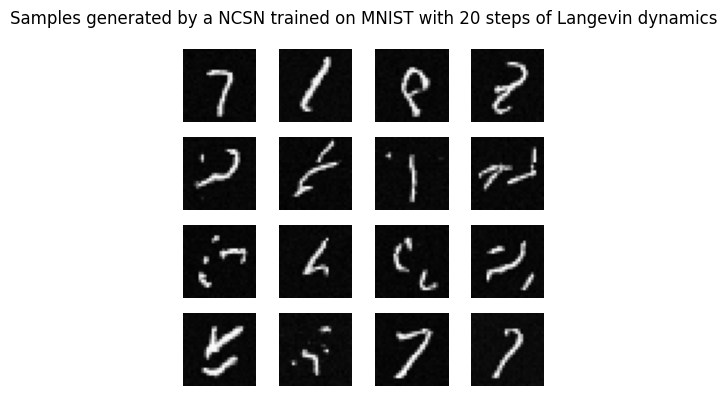

100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


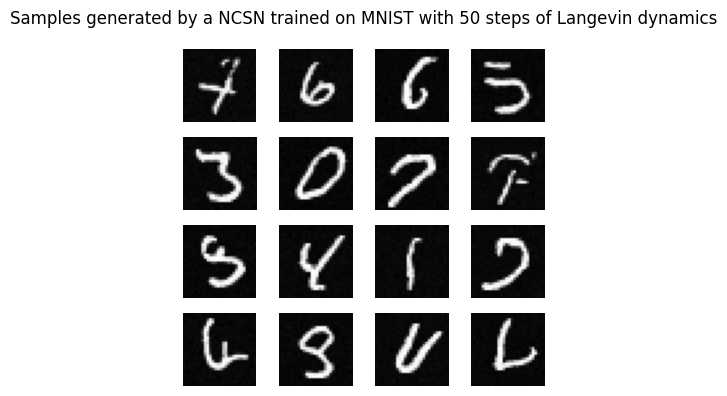

100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


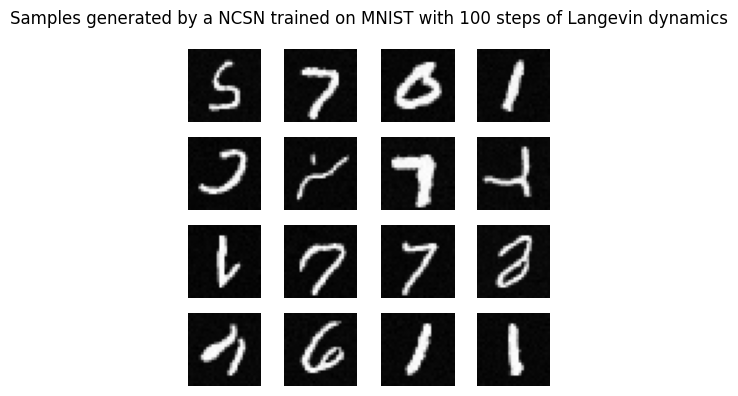

100%|██████████| 200/200 [00:34<00:00,  5.79it/s]


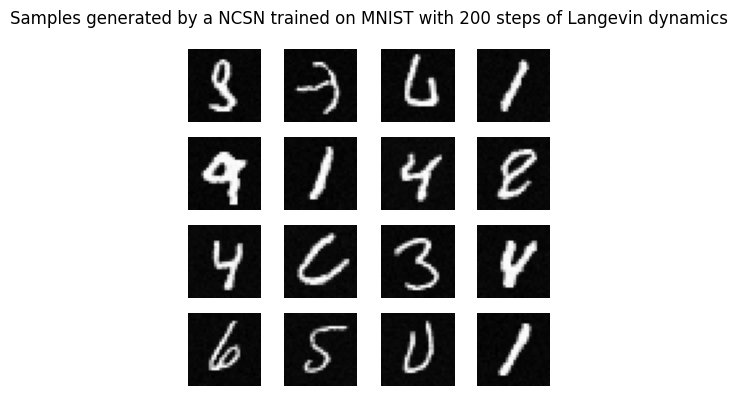

In [12]:
for n_steps in [20, 50, 100, 200]:
    generate_samples(model2, (16, 1, 28, 28), noise_scales, device, n_steps, 2e-5, f"refinenet_samples_{n_steps}_steps.png", f"Samples generated by a NCSN trained on MNIST with {n_steps} steps of Langevin dynamics")

100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


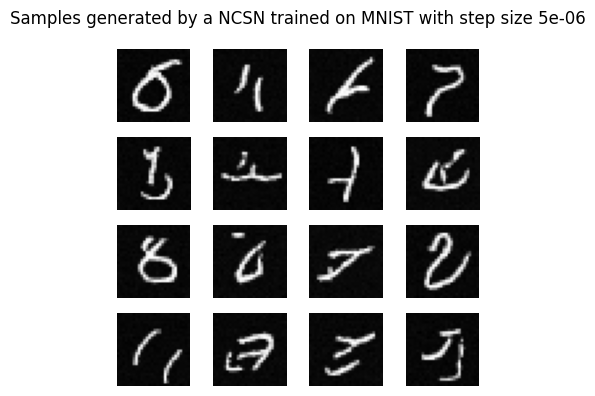

100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


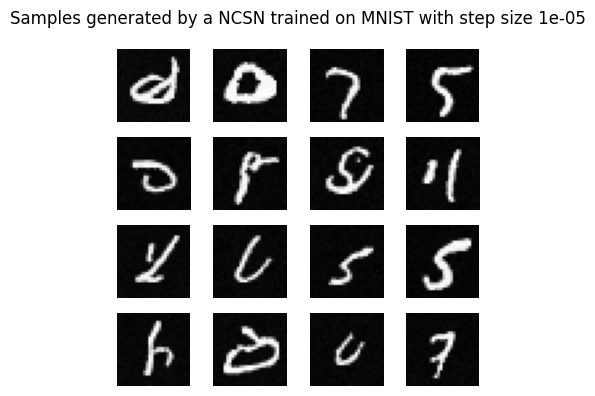

100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


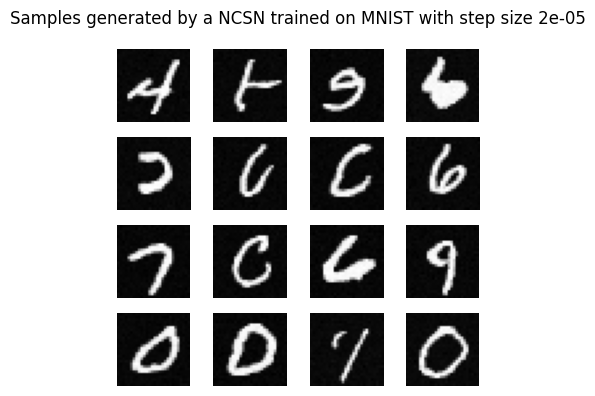

100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


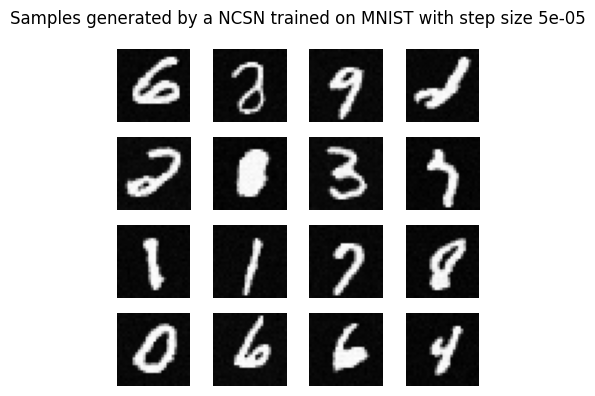

100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


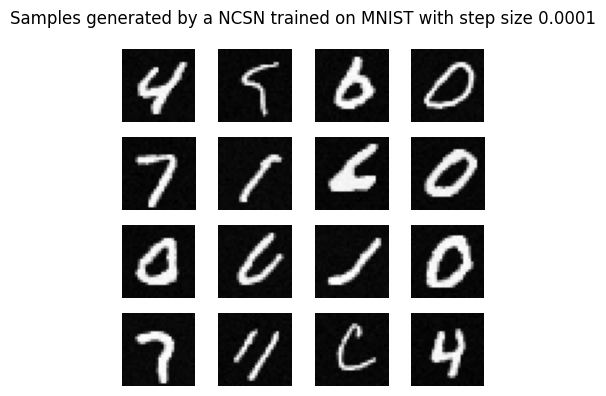

In [13]:
for eps in [5e-6, 1e-5, 2e-5, 5e-5, 1e-4]:
    generate_samples(model2, (16, 1, 28, 28), noise_scales, device, 100, eps, f"refinenet_samples_{eps}_eps.png", f"Samples generated by a NCSN trained on MNIST with step size {eps}")

In [16]:
from torchvision.utils import save_image
refinenet_sample = sample_refinenet(model2, (64, 1, 28, 28), noise_scales, device, 100, 2e-5)
save_image(torch.tensor(refinenet_sample), 'SampledSMLD.png', nrow=8)

100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


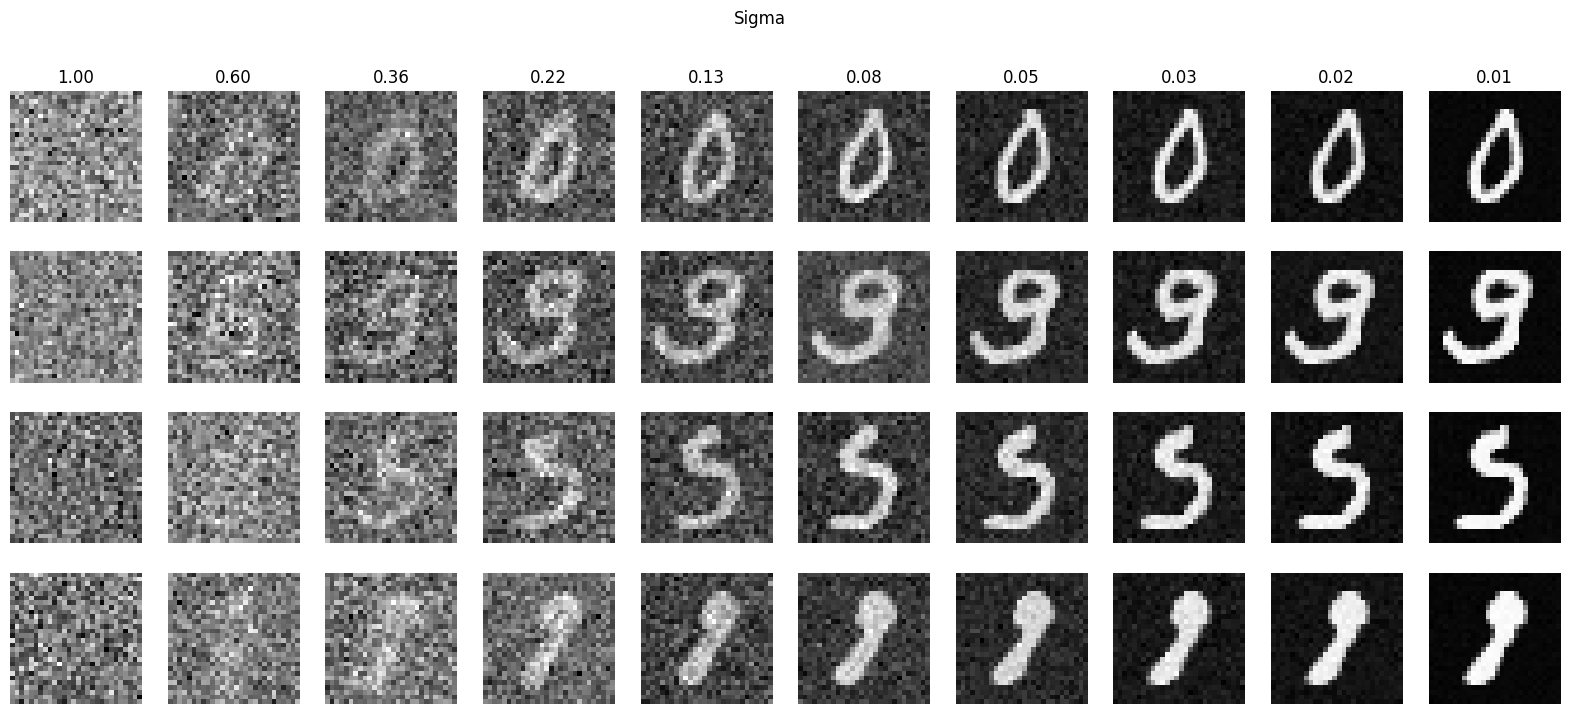

In [17]:
final_sample = sample_refinenet(model2, (4, 1, 28, 28), noise_scales, device, 100, visualize_dynamics_file="visualized_process.png")